In [1]:
import os
import sys
from collections import Counter
from typing import List, Tuple, Type
from glob import glob
import pandas as pd
from scipy import io
import wfdb
import numpy as np
from tqdm import tqdm
import pickle
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

In [2]:
def process_label(df: pd.DataFrame) -> np.ndarray:
    labels = np.zeros([df.shape[0], 9])

    labels_first = df.First_label.values
    labels_second = df.Second_label.values
    labels_third = df.Third_label.values

    # labels = [1 - 9] -> label_index = [0 - 8]
    for i in range(df.shape[0]):
        # Validate: normal labeled sample has no other labels.
        if labels_first[i] == 1:
            assert(np.isnan(labels_second[i]) \
                   and np.isnan(labels_third[i]))

        labels[i, labels_first[i] - 1] = 1
        if not np.isnan(labels_second[i]):
            labels[i, int(labels_second[i]) - 1] = 1
        if not np.isnan(labels_third[i]):
            labels[i, int(labels_third[i]) - 1] = 1
    return labels

In [3]:
load_dir = '/home/gridsan/ybo/advaug/data/cpsc2018/raw'
cpsc_reference = "TrainingSet3/REFERENCE.csv"
reference_file = os.path.join(load_dir, cpsc_reference)
filelist_df = pd.read_csv(reference_file)
signals = filelist_df.Recording.values
labels = process_label(filelist_df)

In [4]:
msss_1 = MultilabelStratifiedShuffleSplit(
    n_splits=1, test_size=0.2, random_state=1)

for train_idx, test_idx in msss_1.split(signals, labels):
    pass

msss_2 = MultilabelStratifiedShuffleSplit(
    n_splits=1, test_size=0.5, random_state=1)

for valid_idx, test_idx in msss_2.split(signals[test_idx], labels[test_idx]):
    pass

f_train, f_valid, f_test =\
    signals[train_idx], signals[valid_idx], signals[test_idx]
y_train, y_valid, y_test =\
    labels[train_idx], labels[valid_idx], labels[test_idx]

In [5]:
def open_ecg_files(target_files):
    signals = []
    for target_file in tqdm(target_files):
        target_path = os.path.join(load_dir, "*", target_file+".mat")
        mat_file = glob(target_path)[0]
        record = io.loadmat(mat_file) # [`Sex`, `Age`, `ECG`]
        signals.append(record["ECG"][0][0][2]) # num_lead = 12, sequence_length
    return signals

In [6]:
X_train = open_ecg_files(f_train)
X_val = open_ecg_files(f_valid)
X_test = open_ecg_files(f_test)

100%|██████████| 690/690 [00:15<00:00, 43.42it/s]


In [9]:
def align_signal_length(signals):
    aligned_signals = []
    for signal in signals:
        signal_length = signal.shape[-1]
        if signal_length > 5000:
            signal = signal[:,:5000]
        elif signal_length < 5000:
            pad_length = 5000 - signal_length
            pad = np.zeros([pad_length, signal.shape[1]])
            signal = np.concatenate([pad, signal], axis=0)
        aligned_signals.append(signal)
#     aligned_signals = np.stack(aligned_signals)
    return aligned_signals

In [10]:
X_train_aligned = align_signal_length(X_train)
X_val_aligned = align_signal_length(X_val)
X_test_aligned = align_signal_length(X_test)

In [27]:
seed = 2
save_path = "/home/gridsan/ybo/advaug/data/cpsc2018/seed{}".format(seed)
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [26]:
with open("/home/gridsan/ybo/advaug/data/cpsc2018/train.pkl",'wb') as f:
    pickle.dump(X_train_aligned,f)
with open("/home/gridsan/ybo/advaug/data/cpsc2018/val.pkl",'wb') as f:
    pickle.dump(X_val_aligned,f)
with open("/home/gridsan/ybo/advaug/data/cpsc2018/test.pkl",'wb') as f:
    pickle.dump(X_test_aligned,f)

FileNotFoundError: [Errno 2] No such file or directory: '/home/gridsan/ybo/advaug/data/cpsc2018/seed2/train.pkl'

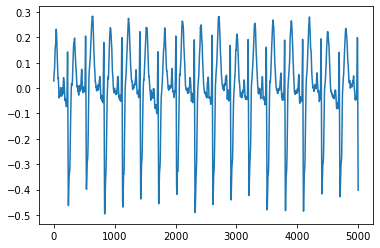

In [17]:
from matplotlib import pyplot as plt

plt.plot(X_train_aligned[0][0])

In [7]:
# with open("/home/gridsan/ybo/CLOCS/data/chapman/contrastive_ss/leads_12/frames_phases_chapman.pkl",'rb') as f:
#             input_array = pickle.load(f)
with open("/home/gridsan/ybo/CLOCS/data/chapman/contrastive_ss/leads_12/labels_phases_chapman.pkl",'rb') as f:
            labels_array = pickle.load(f)

In [10]:
x = input_array['ecg'][1]['train']['All Terms']
y = labels_array['ecg'][1]['train']['All Terms']
y

array([[0, 0, 0, ..., 0, 0, 0],
       [2, 2, 2, ..., 2, 2, 2],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [3, 3, 3, ..., 3, 3, 3],
       [1, 1, 1, ..., 1, 1, 1]])

In [13]:
from scipy.signal import resample
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
enc = LabelEncoder()

In [26]:
dataset = 'chapman'
basepath = '/home/gridsan/ybo/CLOCS/data/chapman/'
trial = 'contrastive_ms' #'contrastive_ss' # '' | 'contrastive_ms' | 'contrastive_ml' | 'contrastive_msml' | 'contrastive_ss'

files = os.listdir(os.path.join(basepath,'ECGDataDenoised'))
database = pd.read_csv(os.path.join(basepath,'Diagnostics.csv'))
dates = database['FileName'].str.split('_',expand=True).iloc[:,1]
dates.name = 'Dates'
dates = pd.to_datetime(dates)
database_with_dates = pd.concat((database,dates),1)
#""" Unique Dates in Database """
#enc.fit(dates)

""" Combine Rhythm Labels """
old_rhythms = ['AF','SVT','ST','AT','AVNRT','AVRT','SAAWR','SI','SA']
new_rhythms = ['AFIB','GSVT','GSVT','GSVT','GSVT','GSVT','GSVT','SR','SR']
database_with_dates['Rhythm'] = database_with_dates['Rhythm'].replace(old_rhythms,new_rhythms)
unique_labels = database_with_dates['Rhythm'].value_counts().index.tolist()
enc.fit(unique_labels)

""" Combine Dates """
def combine_dates(date):
    new_dates = ['All Terms']#use this for continual learning dataset ['Term 1','Term 2','Term 3']
    cutoff_dates = ['2019-01-01']##use this for continual learning dataset ['2018-01-16','2018-02-09','2018-12-30']
    cutoff_dates = [pd.Timestamp(date) for date in cutoff_dates]
    for t,cutoff_date in enumerate(cutoff_dates):
        if date < cutoff_date:
            new_date = new_dates[t]
            break
    return new_date
database_with_dates['Dates'] = database_with_dates['Dates'].apply(combine_dates)

#%%
""" Look at Label Composition """
#""" GroupBy output can be treated as an interable """
groupby_dates = database_with_dates.groupby('Dates')
groupby_dates['Rhythm'].value_counts()

/state/partition1/slurm_tmp/19172587.0.0/ipykernel_60356/1335082236.py:10: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  database_with_dates = pd.concat((database,dates),1)


Dates      Rhythm
All Terms  SB        3889
           GSVT      2307
           AFIB      2225
           SR        2225
Name: Rhythm, dtype: int64

In [32]:
phases = ['train','val','test']
phase_fractions = [0.8, 0.1, 0.1]
phase_fractions_dict = dict(zip(phases,phase_fractions))

term_phase_patients = dict()
term = "All Terms"
term_phase_patients[term] = dict()
term_patients = database_with_dates['FileName'][database_with_dates['Dates'] == term]
random_term_patients = term_patients.sample(frac=1,random_state=0)
start = 0
for phase,fraction in phase_fractions_dict.items():
    if phase == 'test':
        phase_patients = random_term_patients.iloc[start:].tolist() #to avoid missing last patient due to rounding
    else:
        npatients = int(fraction*len(term_patients))
        phase_patients = random_term_patients.iloc[start:start+npatients].tolist()
    term_phase_patients[term][phase] = phase_patients
    start += npatients

In [70]:
random_term_patients

6121    MUSE_20180113_135045_85000
5173    MUSE_20180113_075515_49000
7052    MUSE_20180113_131421_44000
3759    MUSE_20180209_121003_67000
6526    MUSE_20180209_173904_56000
                   ...            
9225    MUSE_20180113_174454_52000
4859    MUSE_20180112_124508_91000
3264    MUSE_20180118_131538_09000
9845    MUSE_20180113_122543_14000
2732    MUSE_20180210_122936_38000
Name: FileName, Length: 10646, dtype: object

In [41]:
sampling_rate = 500
modality_list = ['ecg']
fraction_list = [1]
leads = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
desired_leads = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
inputs_dict = dict()
outputs_dict = dict()
pids = dict()

for phase in phases:
    current_patients = term_phase_patients[term][phase]
    current_inputs = []
    current_outputs = []
    current_pids = []
    for patient in tqdm(current_patients):
        filename = patient + '.csv'
        data = pd.read_csv(os.path.join(basepath,'ECGDataDenoised',filename)) #SxL
        
        resampling_length = 5000
        data_resampled = resample(data,resampling_length)
        data_resampled = data_resampled.T #12x2500
        lead_indices = np.where(np.in1d(leads,desired_leads))[0]
        data_resampled = data_resampled[lead_indices,:] #12x2500
        
        label = database_with_dates['Rhythm'][database_with_dates['FileName']==patient]
        encoded_label = enc.transform(label).item()

        current_inputs.append(data_resampled) #might need to change to '.extend' instead of '.append' to end up with 2D matrix at the end. 
        current_outputs.append([encoded_label for _ in range(data_resampled.shape[0])])
        current_pids.append([patient for _ in range(data_resampled.shape[0])])
        break
    inputs_dict[phase] = np.array(current_inputs)
    outputs_dict[phase] = np.array(current_outputs)
    pids[phase] = np.array(current_pids)

  0%|          | 0/2130 [00:00<?, ?it/s]


In [52]:
save_path = "/home/gridsan/ybo/advaug/data/chapman/"
inputs_dict['train'].dump(os.path.join(save_path, "X_train.npy"), protocol=4)

In [54]:
y = np.load("/home/gridsan/ybo/advaug/data/chapman/y_train.npy", allow_pickle=True)
x = np.load("/home/gridsan/ybo/advaug/data/chapman/X_train.npy", allow_pickle=True)

(1, 12, 5000)

In [63]:
g = np.empty([0, 12, 5000])
g = np.append(g, x, axis=0)
g = np.append(g, x, axis=0)
g.shape

(2, 12, 5000)

In [89]:
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from itertools import repeat
import math
from scipy.spatial.transform import Rotation as R
import scipy

In [122]:
class ToTensor1D:
    def __call__(self, sample):
        return torch.from_numpy(sample)

class Normalize: 
    def __call__(self, x):
        if isinstance(x, np.ndarray):
            x = (x - np.min(x))/(np.max(x) - np.min(x) + 1e-8)
        elif isinstance(x,torch.Tensor):
            x = (x - torch.min(x))/(torch.max(x) - torch.min(x) + 1e-8)
        return x

class GaussianNoise:
    def __init__(self, sigma=0.05):
        self.sigma = sigma

    def __call__(self, x):
        size = x.shape[-1]
        gauss_noise = np.random.normal(0,self.sigma,size=size)
        x = x + gauss_noise
        return x

class BaselineWander:
    def __init__(
        self,
        max_amplitude=0.5,
        min_amplitude=0,
        max_freq=0.2,
        min_freq=0.01,
        k=3,
        freq=500,
    ):
        self.max_amplitude = max_amplitude
        self.min_amplitude = min_amplitude
        self.max_freq = max_freq
        self.min_freq = min_freq
        self.k = k
        self.freq = freq
    
    def __call__(self, sample):
        new_sample = sample.copy()
        csz, tsz = new_sample.shape
        amp_channel = np.random.normal(1, 0.5, size=(csz, 1))
        c = np.array([i for i in range(12)])
        amp_general = np.random.uniform(self.min_amplitude, self.max_amplitude, size=self.k)
        noise = np.zeros(shape=(1, tsz))
        for k in range(self.k):
            noise += self._apply_baseline_wander(tsz) * amp_general[k]
        noise = (noise * amp_channel).astype(np.float32)
        new_sample[c,:] = new_sample[c,:] + noise[c,:]
        return new_sample.astype(float)
        
    def _apply_baseline_wander(self, tsz):
        f = np.random.uniform(self.min_freq, self.max_freq)
        t = np.linspace(0, tsz-1, tsz)
        r = np.random.uniform(0, 2*np.pi)
        noise = np.cos(2*np.pi*f*(t/self.freq)+r)
        return noise

class BaselineShift:
    def __init__(
        self,
        max_amplitude=0.25,
        min_amplitude=0,
        shift_ratio=0.2,
        num_segment=1,
        freq=500,
    ):
        self.max_amplitude = max_amplitude
        self.min_amplitude = min_amplitude
        self.shift_ratio = shift_ratio
        self.num_segment = num_segment
        self.freq = freq
    
    def __call__(self, sample):
        new_sample = sample.copy()
        csz, tsz = new_sample.shape
        shift_length = tsz * self.shift_ratio
        amp_channel = np.random.choice([1, -1], size=(csz, 1))
        amp_general = np.random.uniform(self.min_amplitude, self.max_amplitude, size=(1,1))
        amp = amp_channel - amp_general
        noise = np.zeros(shape=(csz, tsz))
        for i in range(self.num_segment):
            segment_len = np.random.normal(shift_length, shift_length*0.2)
            t0 = int(np.random.uniform(0, tsz-segment_len))
            t = int(t0+segment_len)
            c = np.array([i for i in range(12)])
            noise[c, t0:t] = 1
        new_sample = new_sample + noise * amp
        return new_sample.astype(float)

class PowerlineNoise:
    def __init__(
        self,
        max_amplitude=0.5,
        min_amplitude=0,
        freq=500,
    ):
        self.max_amplitude = max_amplitude
        self.min_amplitude = min_amplitude
        self.freq = freq

    def __call__(self, sample):
        new_sample = sample.copy()
        csz, tsz = new_sample.shape
        amp = np.random.uniform(self.min_amplitude, self.max_amplitude, size=(1,1))
        f = 50 if np.random.uniform(0,1) > 0.5 else 60
        noise = self._apply_powerline_noise(tsz, f)
        new_sample = new_sample + noise * amp
        return new_sample.astype(float)

    def _apply_powerline_noise(self, tsz, f):
        t = np.linspace(0,tsz-1,tsz)
        phase = np.random.uniform(0,2*np.pi)
        noise = np.cos(2*np.pi*f*(t/self.freq)+phase)
        return noise

class EMGNoise:
    def __init__(
        self,
        max_amplitude=0.1,
        min_amplitude=0,
    ):
        self.max_amplitude = max_amplitude
        self.min_amplitude = min_amplitude
    
    def __call__(self, sample):
        new_sample = sample.copy()
        csz, tsz = new_sample.shape
        amp = np.random.uniform(self.min_amplitude, self.max_amplitude, size=(csz, 1))
        noise = np.random.normal(0, 1, [csz, tsz])
        new_sample = new_sample + noise * amp
        return new_sample.astype(float)
    
class RandomLeadsMask(object):
    def __init__(
        self,
        mask_leads_prob=0.5,
        mask_leads_condition=None,
    ):
        self.mask_leads_prob = mask_leads_prob
    
    def __call__(self, sample):
        new_sample = np.zeros(sample.shape)
        survivors = np.random.uniform(0, 1, size=12) >= self.mask_leads_prob
        new_sample[survivors] = sample[survivors]
        return new_sample.astype(float)


class _3KGTransform:
    def __init__(
        self,
        angle=45,
        scale=1.5,
        mask_ratio=0.5,
        **kwargs
    ):
        self.angle = angle
        self.scale = scale
        self.mask_ratio = mask_ratio
    
    def _get_other_four_leads(self, I, II):
        """calculate other four leads (III, aVR, aVL, aVF) from the first two leads (I, II)"""
        III = -I + II
        aVR = -(I + II) / 2
        aVL = I - II/2
        aVF = -I/2 + II

        return III, aVR, aVL, aVF

    def __call__(self, sample):
        leads_taken = [0,1,6,7,8,9,10,11]
        other_leads = [2,3,4,5]
        sample = sample[leads_taken]

        D_i = np.array(
            [
                [0.156, -0.009, -0.172, -0.073, 0.122, 0.231, 0.239, 0.193],
                [-0.227, 0.886, 0.057, -0.019, -0.106, -0.022, 0.040, 0.048],
                [0.021, 0.102, -0.228, -0.310, -0.245, -0.063, 0.054, 0.108]
            ]
        )
        D = np.linalg.pinv(D_i)

        vcg = D_i @ sample

        if self.angle:
            angles = np.random.uniform(-self.angle, self.angle, size=6)
            R1 = R.from_euler('zyx', angles[:3], degrees=True).as_dcm()
            R2 = R.from_euler('zyx', angles[3:], degrees=True).as_dcm()
        else:
            R1 = np.diag((1,1,1))
            R2 = np.diag((1,1,1))
        
        if self.scale:
            scales = np.random.uniform(1, self.scale, size=6)
            S1 = np.diag(scales[:3])
            S2 = np.diag(scales[3:])
        else:
            S1 = np.diag((1,1,1))
            S2 = np.diag((1,1,1))
        
        res1 = D @ S1 @ R1 @ vcg
        res2 = D @ S2 @ R2 @ vcg

        sample_size = sample.shape[-1]

        ecg1 = np.zeros((12, sample_size))
        ecg2 = np.zeros((12, sample_size))

        ecg1[leads_taken] = res1
        ecg1[other_leads] = self._get_other_four_leads(res1[0], res1[1])

        ecg2[leads_taken] = res2
        ecg2[other_leads] = self._get_other_four_leads(res2[0], res2[1])

        if self.mask_ratio:
            sample_size = sample.shape[-1]
            offset = math.floor(sample_size * self.mask_ratio)

            start_indices = np.random.randint(0, sample_size, size=24)
            end_indices = np.array(
                [
                    s + offset if s + offset <= sample_size else sample_size
                    for s in start_indices
                ]
            )
            leftovers = np.array(
                [
                    s + offset - sample_size if s + offset > sample_size else 0
                    for s in start_indices
                ]
            )

            for i in range(12):
                ecg1[i, start_indices[i]:end_indices[i]] = 0
                ecg1[i, 0:leftovers[i]] = 0
            
                ecg2[i, start_indices[i+12]:end_indices[i+12]] = 0
                ecg2[i, 0:leftovers[i+12]] = 0
        
        return (ecg1, ecg2)


In [109]:
class CollatedTransform:
    """Adds callable base class to implement different transformation pipelines."""

    def __init__(self, augmentations):
        self.augmentations = augmentations.split("_")
        self.transform = transforms.Compose([])

        if 'gaussian' in self.augmentations:
            self.transform = transforms.Compose([self.transform, GaussianNoise()])
        if 'powerline' in self.augmentations:
            self.transform = transforms.Compose([self.transform, PowerlineNoise()])
        if 'wander' in self.augmentations:
            self.transform = transforms.Compose([self.transform, BaselineWander()])
        if 'shift' in self.augmentations:
            self.transform = transforms.Compose([self.transform, BaselineShift()])
        if 'emg' in self.augmentations:
            self.transform = transforms.Compose([self.transform, EMGNoise()])
        if '3kg' in self.augmentations:
            self.transform = transforms.Compose([self.transform, _3KGTransform()])

        self.transform = transforms.Compose([self.transform, 
                                            ToTensor1D(),
                                            Normalize()])
        
        if 'rlm' in self.augmentations:
            self.transform = transforms.Compose([self.transform, RandomLeadsMask()])

    def __call__(self, x):
        return self.transform(x)

    def __repr__(self):
        return str(self.transform)

In [38]:
class DatasetWrapper(Dataset):

    def __init__(self, db_dir, method, phase, seed, positive_pairing=None, augmentations=None, nleads=12):
        self.db_dir = db_dir
        self.positive_pairing = positive_pairing
        self.transform = CollatedTransform(augmentations)
        self.normalize = CollatedTransform("_")
        self.nleads = nleads
        self.method = method
        self.seed = seed 
        self.phase = phase

        self.load_data()

    def load_data(self):
        self.X = np.load(os.path.join(self.db_dir, "seed{}/X_{}.npy".format(self.seed, self.phase)), allow_pickle=True)
        self.y = np.load(os.path.join(self.db_dir, "seed{}/y_{}.npy".format(self.seed, self.phase)), allow_pickle=True)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        sample, label = self.X[idx], self.y[idx]
        label = torch.tensor(label,dtype=torch.long)

        if self.method == "transfer":
            sample = self.normalize(sample)
            return sample.float(), label

        else:
            nsamples = sample.shape[-1]
            if self.positive_pairing == 'CMSC': 
                combined_sample = torch.empty(self.nleads, nsamples, 2)
            elif self.positive_pairing == 'CMLC': 
                combined_sample = torch.empty(1, nsamples, self.nleads)
            elif self.positive_pairing == 'CMSMLC': 
                combined_sample = torch.empty(self.nleads, nsamples, 2)
            elif self.positive_pairing == 'PCLR': 
                combined_sample = torch.empty(self.nleads, nsamples, 2)
            else: 
                combined_sample = torch.empty(self.nleads, nsamples, 2)
                combined_sample[:,:,0] = self.normalize(sample)
                combined_sample[:,:,1] = self.transform(sample)
            
            return combined_sample.float(), label

In [132]:
d = DatasetWrapper(db_dir="/home/gridsan/ybo/advaug/data/chapman", trial="transfer", phase="train", seed=1, positive_pairing=None, augmentations="normalize", nleads=12)

In [15]:
from torch.utils.data import DataLoader, random_split

from pytorch_lightning import LightningDataModule, LightningModule, Trainer
import pytorch_lightning as pl

class ECGDataModule(LightningDataModule):

    def __init__(self, dataset, batch_size, method, seed, positive_pairing, augmentations, nleads, num_workers, do_test=False):
        super().__init__()

        self.db_dir = os.path.join("/home/gridsan/ybo/advaug/data/", dataset)
        self.data_train = DatasetWrapper(self.db_dir, method, "train", seed, positive_pairing=positive_pairing, augmentations=augmentations, nleads=nleads)
        self.data_val = DatasetWrapper(self.db_dir, method, "val", seed, positive_pairing=positive_pairing, augmentations=augmentations, nleads=nleads)
        if do_test:
            self.data_test = DatasetWrapper(self.db_dir, method, "test", seed, positive_pairing=positive_pairing, augmentations=augmentations, nleads=nleads)

        self.batch_size = batch_size
        self.num_workers = num_workers
 
    def train_dataloader(self):
        '''returns training dataloader'''
        return DataLoader(self.data_train, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        '''returns validation dataloader'''
        return DataLoader(self.data_val, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        '''returns test dataloader'''
        return DataLoader(self.data_test, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)


In [16]:
datamodule = ECGDataModule(dataset="cinc2021", num_workers=1,
                           batch_size=32, method="pretrain", seed=1, positive_pairing="SimCLR",
                           augmentations="gaussian", nleads=12)
train_loader = datamodule.train_dataloader()
sample = next(enumerate(train_loader))

In [40]:
d = DatasetWrapper(db_dir="/home/gridsan/ybo/advaug/data/cinc2021", method="pretrain",
                   phase="val", seed=1, positive_pairing="SimCLR", augmentations="gaussian", nleads=12)

In [52]:
idx = 0
sample = d.__getitem__(idx)

ecg = sample[0]
normal = ecg[0]
perturbed = ecg[1]
label = sample[1]

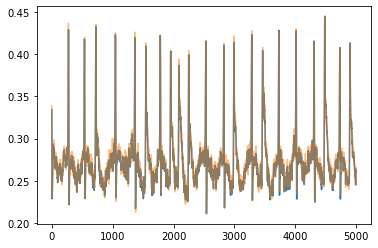

In [50]:
from matplotlib import pyplot as plt

plt.plot(ecg[0,:,0])
plt.plot(ecg[0,:,1], alpha=0.5)
plt.show()

In [124]:
augmentations = "3kg"
transform = CollatedTransform(augmentations)
normalize = CollatedTransform("_")

In [125]:
ecg = d.X[idx]
normal = normalize(ecg)
perturbed = transform(ecg)

TypeError: expected np.ndarray (got tuple)

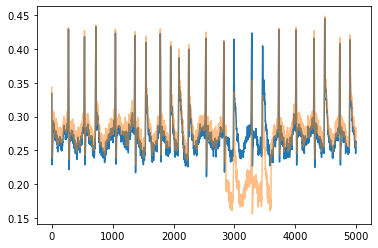

In [117]:
plt.plot(normal[0,:])
plt.plot(perturbed[0,:], alpha=0.5)
plt.show()

In [1]:
import os
import json
from pathlib import Path
import torch
import numpy as np

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger

from setup import parse_args_pretrain

from model.transfer_model import TransferModel
from utils.checkpointer import Checkpointer
from setup import METHODS, NUM_CLASSES, BACKBONES

from data.datamodule import ECGDataModule
import logging 
logging.basicConfig(level=logging.NOTSET)

In [2]:
console_log = logging.getLogger("Lightning")
dataset = "cinc2021"
encoder_name = "resnet"

In [3]:
encoder = BACKBONES[encoder_name]()

MethodClass = METHODS["base"]
model = MethodClass(encoder=encoder, 
                    console_log=console_log, 
                    n_classes=NUM_CLASSES[dataset], 
                    target_type="multilabel",
                    max_epochs=5,
                    batch_size=256,
                    lr=0.001,
                    weight_decay=0,
                    temperature=0.1,
                    proj_hidden_dim=1024,
                    output_dim=128,
                    positive_pairing="SimCLR")

data_module= ECGDataModule(data_dir="/home/gridsan/ybo/advaug/data/", 
                           dataset=dataset, 
                           batch_size=32, 
                           method="pretrain", 
                           seed=42, 
                           positive_pairing="SimCLR",
                           nleads=12, 
                           num_workers=10, 
                           do_test=False,
                          gaussian=True)

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /state/partition1/slurm_tmp/19361980.0.0/tmp27yaqakr
INFO:torch.distributed.nn.jit.instantiator:Writing /state/partition1/slurm_tmp/19361980.0.0/tmp27yaqakr/_remote_module_non_sriptable.py


Resnet with embedding dim 512
Collating Gaussian with sigma=0.05.

Collating Gaussian with sigma=0.05.



In [4]:
data_module.data_train.transform


Compose(
    Compose(
    Compose(
)
)
)

In [5]:
projector = torch.nn.Sequential(
    torch.nn.Linear(encoder.embedding_dim, 2048),
    torch.nn.ReLU(),
    torch.nn.Linear(2048, 128),
)

classifier = torch.nn.Linear(encoder.embedding_dim, NUM_CLASSES[dataset])

In [6]:
data_loader = data_module.train_dataloader()
idx, (X, targets) = next(enumerate(data_loader))

In [20]:
train_dataloader = data_module.train_dataloader()
for batch in train_dataloader:
    (X, targets) = batch
    if len(torch.unique(torch.isnan(X))) > 1:
        nan = X
        nan_y = targets
        print("nan")

In [7]:
feats = encoder(X[:,:,:,0])
logits = classifier(feats.detach())
z = projector(feats)

In [7]:
loss_fn = torch.nn.BCEWithLogitsLoss()
loss_fn(logits, targets.type(torch.float))

tensor(0.6827, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [8]:
loss_fn2 = torch.nn.BCELoss()
logits2 = torch.sigmoid(logits)
loss_fn2(logits2, targets.type(torch.float))

tensor(0.6814, grad_fn=<BinaryCrossEntropyBackward0>)

In [16]:
logits2


tensor([[0.4756, 0.4704, 0.5187, 0.4920, 0.3777, 0.5246, 0.6673, 0.5074, 0.4927,
         0.5722, 0.4410, 0.4298, 0.4984, 0.4886, 0.5376, 0.4242, 0.5262, 0.4382,
         0.4681, 0.4965, 0.5236],
        [0.4625, 0.4585, 0.5157, 0.4784, 0.3758, 0.5360, 0.6579, 0.5189, 0.4730,
         0.5919, 0.4536, 0.4207, 0.5170, 0.4524, 0.5144, 0.4320, 0.5440, 0.4449,
         0.4685, 0.4960, 0.5139],
        [0.4669, 0.4337, 0.5257, 0.5065, 0.3231, 0.4224, 0.6883, 0.4647, 0.5657,
         0.5885, 0.3952, 0.4164, 0.5006, 0.4227, 0.5290, 0.3574, 0.4818, 0.4469,
         0.4815, 0.4749, 0.5692],
        [0.4618, 0.4535, 0.5082, 0.4665, 0.3267, 0.5309, 0.6720, 0.5192, 0.4943,
         0.5655, 0.4222, 0.4851, 0.4538, 0.4340, 0.5346, 0.4132, 0.5257, 0.4239,
         0.4606, 0.4576, 0.5188],
        [0.4374, 0.4493, 0.5276, 0.4833, 0.3347, 0.4974, 0.6934, 0.5171, 0.5232,
         0.5870, 0.3879, 0.4310, 0.4380, 0.4218, 0.5511, 0.3944, 0.5479, 0.4393,
         0.4845, 0.4598, 0.5178],
        [0.4564, 0.4

In [46]:
from data.cinc2021.utils_cinc2021 import evaluate_scores, df_weights_abbr, compute_modified_confusion_matrix, load_weights, compute_auc, compute_accuracy, compute_f_measure, compute_beta_measures,compute_challenge_metric

In [35]:
def evaluate_scores_detailed(
    truth, 
    binary_pred, 
    scalar_pred):

    classes = df_weights_abbr.columns.tolist()
    # sinus_rhythm = "426783006"
    sinus_rhythm = "NSR"
    weights = load_weights(classes=classes)

    _truth = np.array(truth)
    _binary_pred = np.array(binary_pred)
    _scalar_pred = np.array(scalar_pred)

    print("- AUROC and AUPRC...")
    auroc, auprc, auroc_classes, auprc_classes = compute_auc(_truth, _scalar_pred)

    print("- Accuracy...")
    accuracy = compute_accuracy(_truth, _binary_pred)

    print("- F-measure...")
    f_measure, f_measure_classes = compute_f_measure(_truth, _binary_pred)

    print("- F-beta and G-beta measures...")
    # NOTE that F-beta and G-beta are not among metrics of CinC2021, in contrast to CinC2020
    f_beta_measure, g_beta_measure = compute_beta_measures(_truth, _binary_pred, beta=2)

#     print("- Challenge metric...")
#     challenge_metric = compute_challenge_metric(
#         weights, _truth, _binary_pred, classes, sinus_rhythm
#     )
    challenge_metric = 0

    print("Done.")

    # Return the results.
    ret_tuple = (
        auroc,
        auprc,
        auroc_classes,
        auprc_classes,
        accuracy,
        f_measure,
        f_measure_classes,
        f_beta_measure,
        g_beta_measure,
        challenge_metric,
    )
    return ret_tuple


In [47]:
def compute_challenge_metric(
    weights,
    labels,
    outputs,
    classes,
    sinus_rhythms) :
    """checked,"""
    num_recordings, num_classes = np.shape(labels)
    if sinus_rhythm in classes:
        sinus_rhythm_index = classes.index(sinus_rhythm)
    else:
        raise ValueError("The sinus rhythm class is not available.")

    # Compute the observed score.
    A = compute_modified_confusion_matrix(labels, outputs)
    observed_score = np.nansum(weights * A)

    # Compute the score for the model that always chooses the correct label(s).
    correct_outputs = labels
    A = compute_modified_confusion_matrix(labels, correct_outputs)
    correct_score = np.nansum(weights * A)

    # Compute the score for the model that always chooses the sinus rhythm class.
    inactive_outputs = np.zeros((num_recordings, num_classes), dtype=np.bool)
    inactive_outputs[:, sinus_rhythm_index] = 1
    A = compute_modified_confusion_matrix(labels, inactive_outputs)
    inactive_score = np.nansum(weights * A)

    if correct_score != inactive_score:
        normalized_score = float(observed_score - inactive_score) / float(
            correct_score - inactive_score
        )
    else:
        normalized_score = 0.0

    return normalized_score


In [49]:
classes = df_weights_abbr.columns.tolist()
sinus_rhythm = 'NSR'
weights = load_weights(classes=classes)

challenge_metric = compute_challenge_metric(
        weights, targets.detach().numpy(), (logits2>0.5).float().detach().numpy(), classes, sinus_rhythm
    )

ValueError: operands could not be broadcast together with shapes (30,30) (21,21) 

In [48]:
auroc, auprc, _, _, accuracy, f_measure, _, f_beta_measure, g_beta_measure, challenge_metric = \
    evaluate_scores_detailed(targets.detach().numpy(), (logits2>0.5).float().detach().numpy(), logits.detach().numpy())
print("auroc = {}\nauprc = {}\naccuracy = {}\nf_measure = {}\nf_beta_measure = {}\ng_beta_measure = {}\nchallenge_metric = {}".format(auroc, auprc, accuracy, f_measure, f_beta_measure, g_beta_measure, challenge_metric))


- AUROC and AUPRC...
- Accuracy...
- F-measure...
- F-beta and G-beta measures...
Done.
auroc = 0.5446597869220151
auprc = 0.34138767627208755
accuracy = 0.0
f_measure = 0.1118140243902439
f_beta_measure = 0.1582248500853152
g_beta_measure = 0.06870540820216764
challenge_metric = 0


In [56]:
weights

array([[1.    , 0.5   , 0.475 , 0.3   , 0.475 , 0.4   , 0.3   , 0.3   ,
        0.35  , 0.35  , 0.3   , 0.425 , 0.45  , 0.35  , 0.25  , 0.3375,
        0.375 , 0.425 , 0.375 , 0.4   , 0.35  , 0.3   , 0.3   , 0.375 ,
        0.5   , 0.5   , 0.475 , 0.4   , 0.3375, 0.375 ],
       [0.5   , 1.    , 0.475 , 0.3   , 0.475 , 0.4   , 0.3   , 0.3   ,
        0.35  , 0.35  , 0.3   , 0.425 , 0.45  , 0.35  , 0.25  , 0.3375,
        0.375 , 0.425 , 0.375 , 0.4   , 0.35  , 0.3   , 0.3   , 0.375 ,
        0.5   , 0.5   , 0.475 , 0.4   , 0.3375, 0.375 ],
       [0.475 , 0.475 , 1.    , 0.325 , 0.475 , 0.425 , 0.325 , 0.325 ,
        0.375 , 0.375 , 0.325 , 0.45  , 0.475 , 0.375 , 0.275 , 0.3625,
        0.4   , 0.45  , 0.4   , 0.375 , 0.375 , 0.325 , 0.325 , 0.4   ,
        0.475 , 0.475 , 0.475 , 0.425 , 0.3625, 0.4   ],
       [0.3   , 0.3   , 0.325 , 1.    , 0.325 , 0.4   , 0.5   , 0.5   ,
        0.45  , 0.45  , 0.5   , 0.375 , 0.35  , 0.45  , 0.45  , 0.4625,
        0.425 , 0.375 , 0.425 , 0.2  